# Analytics for Keyword Expansion

Let's imagine we are sitting in the marketing department of a company selling jewelry. We need to plan a campaign with some corner points:
- it should be running on Facebook Ads
- it should be approximately a month long
- we should spend ballpark 500 USD on it daily
- the ad creative is not perfectly set, but should be centered around the term "embrace your individuality"

Now, we have to find keywords to target the ad with.

In order to do that, we have past campaign data at our disposal. In this notebook the aim is to showcase how to drill through the data effectively to help our efforts finding the best keywords.

In [1]:
%pip install superlinked==19.21.2
%pip install matplotlib

In [2]:
from datetime import datetime, timedelta
import os
import sys
import warnings
import altair as alt
import pandas as pd
from superlinked import framework as sl

alt.data_transformers.disable_max_rows()
alt.renderers.enable(sl.get_altair_renderer())
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 50)
pd.set_option("display.float_format", lambda x: f"{x:.3f}")
# silence torch warning from sentence_transformers
warnings.filterwarnings("ignore", category=UserWarning, message="TypedStorage is deprecated")

END_OF_2022_12_10_TS = int(datetime(2022, 12, 11).timestamp())
EXECUTOR_DATA = {sl.CONTEXT_COMMON: {sl.CONTEXT_COMMON_NOW: END_OF_2022_12_10_TS}}

In [3]:
def describe_with_percentiles(
    series: pd.Series,
    percentiles: list[float] | None = None,
) -> pd.Series:
    """
    Wrapper around pd.series.describe() giving the percentiles arg a different default.
    """
    if percentiles is None:
        percentiles = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.995]
    return series.describe(percentiles=percentiles)

In [4]:
DATASET_URL: str = (
    "https://storage.googleapis.com/superlinked-notebook-analytics-keyword-expansion-ads/marketing-dataset-filtered.csv"
)
USE_COLUMNS: list[str] = [
    "time",
    "media_cost_usd",
    "no_of_days",
    "search_tags",
    "keywords",
    "ext_service_name",
    "clicks",
]

## Load and clean dataset

In [5]:
NROWS = int(os.getenv("NOTEBOOK_TEST_ROW_LIMIT", str(sys.maxsize)))
dataset = pd.read_csv(DATASET_URL, nrows=NROWS).reset_index()
dataset.head()

,index,campaign_item_id,no_of_days,time,ext_service_id,ext_service_name,creative_id,creative_width,creative_height,search_tags,template_id,landing_page,advertiser_id,advertiser_name,network_id,approved_budget,advertiser_currency,channel_id,channel_name,max_bid_cpm,network_margin,campaign_budget_usd,impressions,clicks,stats_currency,currency_code,exchange_rate,media_cost_usd,position_in_content,unique_reach,total_reach,search_tag_cat,cmi_currency_code,timezone,weekday_cat,keywords
0,0,2733,9,2022-05-03,128,Facebook Ads,1000,300.000,250.000,#Embrace Your Individuality with X,90.000,https://www.abcjewelry.com/collections/boho-je...,4756,Web,190,400.000,SGD,8,Social,NaN,0.000,652.174,2135,32,SGD,SGD,1,109.420,NaN,NaN,NaN,Others,SGD,Asia/Singapore,week_day,artisan jewelry
1,1,2766,54,2022-06-01,4,Google Ads,1005,0.000,0.000,#The Ultimate Fashion Statement with X,23.000,https://www.abcjewelry.com/collections/gemston...,5191,Brand,287,1000.000,USD,32,Mobile,1.000,0.000,760.000,876,18,USD,USD,1,43.151,NaN,NaN,NaN,Youtube,USD,America/New_York,week_day,bridal jewelry
2,2,2766,55,2022-06-02,16,DV360,1005,0.000,0.000,#The Ultimate Fashion Statement with X,23.000,https://www.abcjewelry.com/collections/stateme...,5191,Brand,287,1000.000,USD,1,Display,1.000,0.000,760.000,790,12,USD,USD,1,31.436,NaN,NaN,NaN,Youtube,USD,America/New_York,week_day,unique and trendy jewelry
3,3,2766,58,2022-06-05,128,Facebook Ads,1005,0.000,0.000,#Embrace Your Individuality with X,23.000,https://www.abcjewelry.com/collections/gemston...,5191,Brand,287,1000.000,USD,4,Search,1.000,0.000,760.000,655,12,USD,USD,1,13.351,NaN,NaN,NaN,Youtube,USD,America/New_York,week_end,artisan jewelry
4,4,2766,62,2022-06-09,128,Facebook Ads,1005,0.000,0.000,#Embrace Your Individuality with X,23.000,https://www.abcjewelry.com/collections/pendant...,5191,Brand,287,1000.000,USD,64,Video,1.000,0.000,760.000,622,10,USD,USD,1,13.629,NaN,NaN,NaN,Youtube,USD,America/New_York,week_day,rhinestone jewelry


In [6]:
filtered_dataset = dataset.loc[:, USE_COLUMNS].reset_index().copy()
# filtering for campaigns with spending and days info",
filtered_dataset = filtered_dataset[filtered_dataset["no_of_days"] > 0]
filtered_dataset = filtered_dataset[filtered_dataset["media_cost_usd"] > 0]
# calculate and clean",
filtered_dataset["time"] = [int(f.timestamp()) for f in pd.to_datetime(filtered_dataset.loc[:, "time"])]
filtered_dataset["daily_cost"] = filtered_dataset.loc[:, "media_cost_usd"] / filtered_dataset.loc[:, "no_of_days"]
filtered_dataset["daily_click"] = filtered_dataset.loc[:, "clicks"] / filtered_dataset.loc[:, "no_of_days"]
filtered_dataset["cost_per_click"] = filtered_dataset.loc[:, "media_cost_usd"] / filtered_dataset.loc[:, "clicks"]
filtered_dataset.shape

(23886, 11)

In [7]:
# uncomment this line to run on a smaller sample of data for a lightning fast run
# filtered_dataset = filtered_dataset.sample(2000)

## Data exploration

To find the right space parameters.

<Axes: >

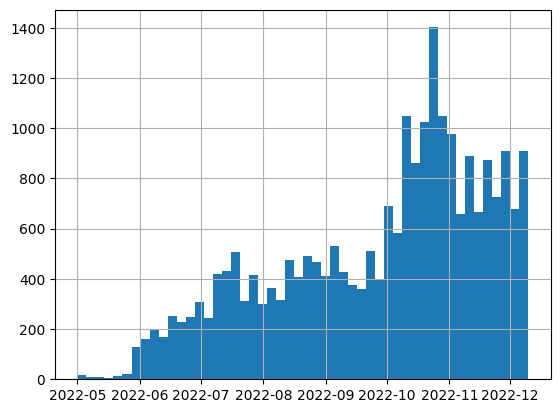

In [8]:
pd.to_datetime(filtered_dataset["time"], unit="s").hist(bins=50)

Recency space should have two period times - one for the frequent 2 months, and 8 months to cover the whole span of time campaigns happened.

See other space parameters inline with the corresponding table creation.

In [9]:
# encode between [0-100] using NumberSpace with Similar mode
# as we might prefer varying campaign lengths based on our preferences
describe_with_percentiles(filtered_dataset["no_of_days"])

count   23886.000
mean       27.798
std        25.445
min         1.000
5%          2.000
10%         4.000
25%         9.000
50%        20.000
75%        37.000
90%        65.000
95%        85.000
99%       111.150
99.5%     115.000
max       118.000
Name: no_of_days, dtype: float64

In [10]:
# very skewed, depends on no_of_days, not embedding it!
describe_with_percentiles(filtered_dataset["clicks"])

count   23886.000
mean       52.834
std       365.499
min         2.000
5%          3.000
10%         3.000
25%         5.000
50%         8.000
75%        13.000
90%        82.000
95%       157.000
99%       742.150
99.5%    1431.675
max     20644.000
Name: clicks, dtype: float64

In [11]:
# encode between [0, 50] outliers would skew the distribution.
# Use NumberSpace with Similar mode as we might have different budgets
describe_with_percentiles(filtered_dataset["daily_cost"])

count   23886.000
mean        2.067
std        23.388
min         0.000
5%          0.002
10%         0.005
25%         0.018
50%         0.085
75%         0.642
90%         3.341
95%         6.861
99%        29.464
99.5%      46.276
max      2295.029
Name: daily_cost, dtype: float64

In [12]:
# encode between [0, 100] outliers would skew the distribution.
# Use NumberSpace with Maximum Mode as we prefer better daily_click bringing campaigns all else being equal
describe_with_percentiles(filtered_dataset["daily_click"])

count   23886.000
mean        7.773
std        93.427
min         0.017
5%          0.065
10%         0.091
25%         0.174
50%         0.400
75%         1.556
90%         9.564
95%        22.650
99%       107.858
99.5%     205.331
max      8090.000
Name: daily_click, dtype: float64

In [13]:
# encode between [0, 2] outliers would skew the distribution.
# Use NumberSpace with Minimum Mode as we prefer campaigns that achieve a click spending less dollars.
# Measured in thousand USD.
describe_with_percentiles(filtered_dataset["cost_per_click"])

count   23886.000
mean        0.402
std         0.666
min         0.000
5%          0.011
10%         0.023
25%         0.070
50%         0.204
75%         0.450
90%         0.947
95%         1.439
99%         3.253
99.5%       4.262
max        15.728
Name: cost_per_click, dtype: float64

In [14]:
# low cardinality categorical variable, let's use CategoricalSimilaritySpace!
filtered_dataset["ext_service_name"].value_counts()

ext_service_name
Facebook Ads    7972
Google Ads      7957
DV360           7957
Name: count, dtype: int64

In [15]:
filtered_dataset.head()

,index,time,media_cost_usd,no_of_days,search_tags,keywords,ext_service_name,clicks,daily_cost,daily_click,cost_per_click
0,0,1651536000,109.420,9,#Embrace Your Individuality with X,artisan jewelry,Facebook Ads,32,12.158,3.556,3.419
1,1,1654041600,43.151,54,#The Ultimate Fashion Statement with X,bridal jewelry,Google Ads,18,0.799,0.333,2.397
2,2,1654128000,31.436,55,#The Ultimate Fashion Statement with X,unique and trendy jewelry,DV360,12,0.572,0.218,2.620
3,3,1654387200,13.351,58,#Embrace Your Individuality with X,artisan jewelry,Facebook Ads,12,0.230,0.207,1.113
4,4,1654732800,13.629,62,#Embrace Your Individuality with X,rhinestone jewelry,Facebook Ads,10,0.220,0.161,1.363


## Set up Superlinked

In [16]:
class Campaign(sl.Schema):
    id: sl.IdField
    start_date: sl.Timestamp
    number_of_days: sl.Integer
    creative: sl.String
    keywords: sl.String
    ext_service_name: sl.StringList
    daily_cost: sl.Float
    daily_click: sl.Float
    cost_per_click: sl.Float

In [17]:
campaign = Campaign()

In [18]:
# use parameters derived above from plots and tables
recency_space = sl.RecencySpace(
    timestamp=campaign.start_date,
    period_time_list=[
        sl.PeriodTime(timedelta(days=60)),
        sl.PeriodTime(timedelta(days=180)),
    ],
)
num_days_space = sl.NumberSpace(number=campaign.number_of_days, min_value=1, max_value=100, mode=sl.Mode.SIMILAR)
daily_cost_space = sl.NumberSpace(number=campaign.daily_cost, min_value=0, max_value=50, mode=sl.Mode.SIMILAR)
daily_click_space = sl.NumberSpace(number=campaign.daily_click, min_value=0, max_value=100, mode=sl.Mode.MAXIMUM)
cost_per_click_space = sl.NumberSpace(number=campaign.daily_click, min_value=0, max_value=2, mode=sl.Mode.MINIMUM)
service_space = sl.CategoricalSimilaritySpace(
    category_input=campaign.ext_service_name,
    categories=filtered_dataset["ext_service_name"].unique().tolist(),
    negative_filter=-5.0,
)
# textual data is simply encoded using a reasonably large and well performing model
creative_space = sl.TextSimilaritySpace(text=campaign.creative, model="sentence-transformers/all-mpnet-base-v2")
keywords_space = sl.TextSimilaritySpace(text=campaign.keywords, model="sentence-transformers/all-mpnet-base-v2")

In [19]:
campaign_index = sl.Index(
    spaces=[
        recency_space,
        num_days_space,
        daily_cost_space,
        daily_click_space,
        cost_per_click_space,
        service_space,
        creative_space,
        keywords_space,
    ]
)

In [20]:
campaign_df_parser = sl.DataFrameParser(
    schema=campaign,
    mapping={
        campaign.id: "index",
        campaign.start_date: "time",
        campaign.number_of_days: "no_of_days",
        campaign.creative: "search_tags",
    },
)

In [21]:
source_campaign: sl.InMemorySource = sl.InMemorySource(campaign, parser=campaign_df_parser)
executor: sl.InMemoryExecutor = sl.InMemoryExecutor(
    sources=[source_campaign], indices=[campaign_index], context_data=EXECUTOR_DATA
)
app: sl.InMemoryApp = executor.run()

In [22]:
source_campaign.put([filtered_dataset])

## Run queries

In [23]:
# a query to browse campaign data without taking a specific campaign as base
# define a versatile query and simply just switch in features as we go
campaign_discovery_query = (
    sl.Query(
        campaign_index,
        weights={
            keywords_space: sl.Param("keywords_weight"),
            creative_space: sl.Param("creative_weight"),
            service_space: sl.Param("service_weight"),
            cost_per_click_space: sl.Param("cost_per_click_weight"),
            daily_cost_space: sl.Param("daily_cost_weight"),
            daily_click_space: sl.Param("daily_click_weight"),
            num_days_space: sl.Param("num_days_weight"),
            recency_space: sl.Param("recency_weight"),
        },
    )
    .find(campaign)
    .similar(num_days_space, sl.Param("target_length_in_days"))
    .similar(daily_cost_space, sl.Param("target_daily_cost"))
    .similar(creative_space, sl.Param("target_creative"))
    .similar(keywords_space, sl.Param("target_keywords"))
    .similar(service_space, sl.Param("target_service"))
    .select_all()
    .limit(sl.Param("limit"))
)

In [25]:
# first let's just switch the search on in terms of the text of the creative of the ad
only_search_tag_results = app.query(
    campaign_discovery_query,
    keywords_weight=0,
    creative_weight=1,
    service_weight=0,
    cost_per_click_weight=0,
    daily_cost_weight=0,
    daily_click_weight=0,
    num_days_weight=0,
    recency_weight=0,
    target_length_in_days=0.0,
    target_daily_cost=0,
    target_creative="embrace your individuality",
    target_keywords="",
    target_service="",
    limit=10,
)

# these are essentially in random order, as there are only 2 distinct creatives at the moment
df = sl.PandasConverter.to_pandas(only_search_tag_results)
sl.PandasConverter.format_date_column(df, "start_date")

,start_date,number_of_days,creative,keywords,ext_service_name,daily_cost,daily_click,cost_per_click,id,similarity_score
0,2022-05-02,1,#Embrace Your Individuality with X,layered necklaces,[Facebook Ads],489.513,1630.000,0.300,23169,0.074
1,2022-05-02,1,#Embrace Your Individuality with X,body jewelry,[DV360],396.772,1794.000,0.221,23194,0.074
2,2022-05-03,2,#Embrace Your Individuality with X,seasonal jewelry,[DV360],198.378,1029.000,0.193,23195,0.074
3,2022-05-02,1,#Embrace Your Individuality with X,affordable trendy jewelry,[Facebook Ads],346.197,1257.000,0.275,23253,0.074
4,2022-05-11,4,#Embrace Your Individuality with X,affordable trendy jewelry,[Facebook Ads],257.778,799.250,0.323,23382,0.074
5,2022-07-06,2,#Embrace Your Individuality with X,initial jewelry,[Google Ads],166.715,326.000,0.511,7227,0.074
6,2022-08-21,2,#Embrace Your Individuality with X,festival jewelry,[Google Ads],51.151,66.000,0.775,20826,0.074
7,2022-10-08,1,#Embrace Your Individuality with X,crystal jewelry,[Google Ads],66.336,41.000,1.618,5019,0.074
8,2022-10-01,3,#Embrace Your Individuality with X,artisanal jewelry,[DV360],73.403,1250.000,0.059,6770,0.074
9,2022-09-30,1,#Embrace Your Individuality with X,affordable statement jewelry,[Google Ads],87.910,62.000,1.418,6778,0.074


In [26]:
# now let's only consider campaigns on Facebook
search_tag_on_fb_result = app.query(
    campaign_discovery_query,
    keywords_weight=0,
    creative_weight=1,
    service_weight=1,
    cost_per_click_weight=0,
    daily_cost_weight=0,
    daily_click_weight=0,
    num_days_weight=0,
    recency_weight=0,
    target_length_in_days=0,
    target_daily_cost=0,
    target_creative="embrace your individuality",
    target_keywords="",
    target_service="Facebook Ads",
    limit=10,
)

df = sl.PandasConverter.to_pandas(search_tag_on_fb_result)
sl.PandasConverter.format_date_column(df, "start_date")

,start_date,number_of_days,creative,keywords,ext_service_name,daily_cost,daily_click,cost_per_click,id,similarity_score
0,2022-05-02,1,#Embrace Your Individuality with X,layered necklaces,[Facebook Ads],489.513,1630.000,0.300,23169,0.132
1,2022-05-02,1,#Embrace Your Individuality with X,affordable trendy jewelry,[Facebook Ads],346.197,1257.000,0.275,23253,0.132
2,2022-05-11,4,#Embrace Your Individuality with X,affordable trendy jewelry,[Facebook Ads],257.778,799.250,0.323,23382,0.132
3,2022-10-02,1,#Embrace Your Individuality with X,threader earrings,[Facebook Ads],885.025,6569.000,0.135,23832,0.131
4,2022-10-02,1,#Embrace Your Individuality with X,bold jewelry,[Facebook Ads],1094.291,8090.000,0.135,23975,0.131
5,2022-10-01,3,#Embrace Your Individuality with X,formal jewelry,[Facebook Ads],78.958,445.667,0.177,6006,0.131
6,2022-07-08,4,#Embrace Your Individuality with X,animal jewelry,[Facebook Ads],55.599,178.500,0.311,6537,0.131
7,2022-07-06,2,#Embrace Your Individuality with X,zodiac jewelry,[Facebook Ads],83.082,261.000,0.318,6586,0.131
8,2022-10-04,4,#Embrace Your Individuality with X,handmade jewelry,[Facebook Ads],83.707,338.000,0.248,23561,0.131
9,2022-10-10,9,#Embrace Your Individuality with X,beach jewelry,[Facebook Ads],136.750,507.444,0.269,23835,0.131


In [27]:
# now let's take into account that we are looking for ~30 day campaigns
search_tag_fb_30_days_results = app.query(
    campaign_discovery_query,
    keywords_weight=0,
    creative_weight=1,
    service_weight=1,
    cost_per_click_weight=0,
    daily_cost_weight=0,
    daily_click_weight=0,
    num_days_weight=1,
    recency_weight=0,
    target_length_in_days=30.0,
    target_daily_cost=0,
    target_creative="embrace your individuality",
    target_keywords="",
    target_service="Facebook Ads",
    limit=10,
)

df = sl.PandasConverter.to_pandas(search_tag_fb_30_days_results)
sl.PandasConverter.format_date_column(df, "start_date")

,start_date,number_of_days,creative,keywords,ext_service_name,daily_cost,daily_click,cost_per_click,id,similarity_score
0,2022-06-11,29,#Embrace Your Individuality with X,party jewelry,[Facebook Ads],2.859,11.862,0.241,23184,0.171
1,2022-05-25,33,#Embrace Your Individuality with X,luxury jewelry,[Facebook Ads],0.756,2.455,0.308,23173,0.171
2,2022-06-08,26,#Embrace Your Individuality with X,minimalist jewelry,[Facebook Ads],0.785,7.269,0.108,23272,0.171
3,2022-09-17,30,#Embrace Your Individuality with X,dainty jewelry,[Facebook Ads],2.515,9.333,0.269,5906,0.170
4,2022-09-16,29,#Embrace Your Individuality with X,affordable statement jewelry,[Facebook Ads],2.542,12.103,0.210,6663,0.170
5,2022-09-19,32,#Embrace Your Individuality with X,hoop earrings,[Facebook Ads],2.430,6.406,0.379,7133,0.170
6,2022-09-29,28,#Embrace Your Individuality with X,dainty jewelry,[Facebook Ads],0.645,3.071,0.210,5509,0.170
7,2022-08-20,28,#Embrace Your Individuality with X,affordable statement jewelry,[Facebook Ads],2.036,9.964,0.204,5824,0.170
8,2022-09-15,28,#Embrace Your Individuality with X,spring jewelry,[Facebook Ads],1.266,3.250,0.390,6411,0.170
9,2022-08-19,28,#Embrace Your Individuality with X,party jewelry,[Facebook Ads],1.513,6.214,0.243,6444,0.170


In [28]:
# let's also factor in that we aim to spend 0.5 thousand USDs a day
search_tag_fb_30_days_daily_05_results = app.query(
    campaign_discovery_query,
    keywords_weight=0,
    creative_weight=1,
    service_weight=1,
    cost_per_click_weight=0,
    daily_cost_weight=1,
    daily_click_weight=0,
    num_days_weight=1,
    recency_weight=0,
    target_length_in_days=30.0,
    target_daily_cost=0.5,
    target_creative="embrace your individuality",
    target_keywords="",
    target_service="Facebook Ads",
    limit=10,
)

# some extremely low spending campaigns now disappeared from the top results
df = sl.PandasConverter().to_pandas(search_tag_fb_30_days_daily_05_results)
sl.PandasConverter.format_date_column(df, "start_date")

,start_date,number_of_days,creative,keywords,ext_service_name,daily_cost,daily_click,cost_per_click,id,similarity_score
0,2022-05-25,33,#Embrace Your Individuality with X,luxury jewelry,[Facebook Ads],0.756,2.455,0.308,23173,0.204
1,2022-06-08,26,#Embrace Your Individuality with X,minimalist jewelry,[Facebook Ads],0.785,7.269,0.108,23272,0.204
2,2022-06-11,29,#Embrace Your Individuality with X,party jewelry,[Facebook Ads],2.859,11.862,0.241,23184,0.203
3,2022-09-29,28,#Embrace Your Individuality with X,dainty jewelry,[Facebook Ads],0.645,3.071,0.210,5509,0.203
4,2022-08-20,28,#Embrace Your Individuality with X,rhinestone jewelry,[Facebook Ads],0.816,2.607,0.313,7415,0.203
5,2022-08-23,28,#Embrace Your Individuality with X,charm bracelets,[Facebook Ads],1.178,5.321,0.221,24190,0.203
6,2022-09-15,28,#Embrace Your Individuality with X,spring jewelry,[Facebook Ads],1.266,3.250,0.390,6411,0.203
7,2022-08-19,28,#Embrace Your Individuality with X,party jewelry,[Facebook Ads],1.513,6.214,0.243,6444,0.203
8,2022-09-07,33,#Embrace Your Individuality with X,casual jewelry,[Facebook Ads],0.679,2.121,0.320,23919,0.203
9,2022-09-15,28,#Embrace Your Individuality with X,layered bracelets,[Facebook Ads],1.701,7.214,0.236,9478,0.203


### Optimize for a target

Now let's also blend in that we are looking for the best campaigns within these soft filters

#### Clicks

In [29]:
# get the most clicks without regard to cost
search_click_optim_results = app.query(
    campaign_discovery_query,
    keywords_weight=0,
    creative_weight=1,
    service_weight=1,
    cost_per_click_weight=0,
    daily_cost_weight=1,
    daily_click_weight=0.1,
    num_days_weight=1,
    recency_weight=0,
    target_length_in_days=30.0,
    target_daily_cost=0.5,
    target_creative="embrace your individuality",
    target_keywords="",
    target_service="Facebook Ads",
    limit=10,
)

# high click creating campaigns are at the top - regardless of their cost
df = sl.PandasConverter().to_pandas(search_click_optim_results)
sl.PandasConverter.format_date_column(df, "start_date")

,start_date,number_of_days,creative,keywords,ext_service_name,daily_cost,daily_click,cost_per_click,id,similarity_score
0,2022-09-01,24,#Embrace Your Individuality with X,formal jewelry,[Facebook Ads],1.428,150.833,0.009,5427,0.208
1,2022-08-30,25,#Embrace Your Individuality with X,animal jewelry,[Facebook Ads],3.945,342.040,0.012,23932,0.208
2,2022-08-31,26,#Embrace Your Individuality with X,bridal jewelry,[Facebook Ads],4.718,354.462,0.013,23784,0.207
3,2022-09-04,17,#Embrace Your Individuality with X,designer-inspired jewelry,[Facebook Ads],2.315,97.824,0.024,24268,0.207
4,2022-09-02,15,#Embrace Your Individuality with X,everyday jewelry,[Facebook Ads],4.927,425.333,0.012,23951,0.206
5,2022-08-31,13,#Embrace Your Individuality with X,casual jewelry,[Facebook Ads],3.030,117.615,0.026,24266,0.206
6,2022-08-29,24,#Embrace Your Individuality with X,luxury jewelry,[Facebook Ads],5.053,51.958,0.097,6905,0.206
7,2022-09-03,16,#Embrace Your Individuality with X,concert jewelry,[Facebook Ads],3.480,58.562,0.059,23463,0.205
8,2022-08-31,13,#Embrace Your Individuality with X,everyday jewelry,[Facebook Ads],5.750,85.385,0.067,23711,0.205
9,2022-10-16,18,#Embrace Your Individuality with X,victorian jewelry,[Facebook Ads],6.628,66.056,0.100,6776,0.205


In [30]:
# take it to the extreme - be more lenient with daily_cost and no_of_days thresholds
# and favor better performing campaigns
extreme_search_click_optim_results = app.query(
    campaign_discovery_query,
    keywords_weight=0,
    creative_weight=1,
    service_weight=1,
    cost_per_click_weight=0,
    daily_cost_weight=1,
    daily_click_weight=1,
    num_days_weight=1,
    recency_weight=0,
    target_length_in_days=30.0,
    target_daily_cost=0.5,
    target_creative="embrace your individuality",
    target_keywords="",
    target_service="Facebook Ads",
    limit=10,
)

# the results focus even more on the clicks the campaign was able to generate
df = sl.PandasConverter().to_pandas(extreme_search_click_optim_results)
sl.PandasConverter.format_date_column(df, "start_date")

,start_date,number_of_days,creative,keywords,ext_service_name,daily_cost,daily_click,cost_per_click,id,similarity_score
0,2022-09-01,24,#Embrace Your Individuality with X,formal jewelry,[Facebook Ads],1.428,150.833,0.009,5427,0.211
1,2022-08-30,25,#Embrace Your Individuality with X,animal jewelry,[Facebook Ads],3.945,342.040,0.012,23932,0.211
2,2022-08-31,26,#Embrace Your Individuality with X,bridal jewelry,[Facebook Ads],4.718,354.462,0.013,23784,0.210
3,2022-09-04,17,#Embrace Your Individuality with X,designer-inspired jewelry,[Facebook Ads],2.315,97.824,0.024,24268,0.210
4,2022-09-02,15,#Embrace Your Individuality with X,everyday jewelry,[Facebook Ads],4.927,425.333,0.012,23951,0.209
5,2022-08-31,13,#Embrace Your Individuality with X,casual jewelry,[Facebook Ads],3.030,117.615,0.026,24266,0.209
6,2022-08-29,11,#Embrace Your Individuality with X,modern jewelry,[Facebook Ads],6.700,170.818,0.039,23949,0.208
7,2022-08-29,11,#Embrace Your Individuality with X,stud earrings,[Facebook Ads],6.767,128.636,0.053,24072,0.208
8,2022-08-31,13,#Embrace Your Individuality with X,everyday jewelry,[Facebook Ads],5.750,85.385,0.067,23711,0.208
9,2022-10-09,11,#Embrace Your Individuality with X,cuff bracelets,[Facebook Ads],13.028,87.000,0.150,6810,0.205


#### Cost

In [31]:
# Find the most efficient campaigns in terms of cost_per_click
search_cost_optim_results = app.query(
    campaign_discovery_query,
    keywords_weight=0,
    creative_weight=1,
    service_weight=1,
    cost_per_click_weight=1,
    daily_cost_weight=1,
    daily_click_weight=0,
    num_days_weight=1,
    recency_weight=0,
    target_length_in_days=30.0,
    target_daily_cost=0.5,
    target_creative="embrace your individuality",
    target_keywords="",
    target_service="Facebook Ads",
    limit=10,
)

df = sl.PandasConverter().to_pandas(search_cost_optim_results)
sl.PandasConverter.format_date_column(df, "start_date")

,start_date,number_of_days,creative,keywords,ext_service_name,daily_cost,daily_click,cost_per_click,id,similarity_score
0,2022-08-21,31,#Embrace Your Individuality with X,bridal jewelry,[Facebook Ads],0.037,0.065,0.574,15723,0.210
1,2022-07-22,32,#Embrace Your Individuality with X,hoop earrings,[Facebook Ads],0.005,0.062,0.074,20962,0.210
2,2022-07-14,28,#Embrace Your Individuality with X,statement rings,[Facebook Ads],0.006,0.071,0.088,17259,0.210
3,2022-07-19,33,#Embrace Your Individuality with X,renaissance jewelry,[Facebook Ads],0.026,0.091,0.281,11496,0.210
4,2022-08-05,32,#Embrace Your Individuality with X,colorful jewelry,[Facebook Ads],0.046,0.125,0.367,22981,0.209
5,2022-09-19,32,#Embrace Your Individuality with X,affordable statement jewelry,[Facebook Ads],0.009,0.125,0.070,7128,0.209
6,2022-09-01,30,#Embrace Your Individuality with X,chunky jewelry,[Facebook Ads],0.124,0.133,0.927,16796,0.209
7,2022-08-20,30,#Embrace Your Individuality with X,baroque jewelry,[Facebook Ads],0.038,0.133,0.283,15722,0.209
8,2022-08-31,30,#Embrace Your Individuality with X,zodiac jewelry,[Facebook Ads],0.022,0.133,0.163,2591,0.209
9,2022-08-26,24,#Embrace Your Individuality with X,drop earrings,[Facebook Ads],0.020,0.083,0.239,16738,0.209


## What we achieved

Using Superlinked we were able to drill through our campaign dataset by gradually building up a collection of result sets where we are

1. softly favoring campaigns that are similar to our planned one in terms of:
    * length,
    * budget,
    * the ad platform we are targeting and
    * creative text.
<br/><br/>
2. optimize for different metrics having fine-grained control over the tradeoff of relaxing our constraints, but getting better performing campaigns.